In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

elizavetasirotina_ir_challenge_path = kagglehub.dataset_download('elizavetasirotina/ir-challenge')

print('Data source import complete.')


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import json

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [ ]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

# 0.1 Helper functions

## load_json_data

In [ ]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents

## get_mapping_dict

In [ ]:
def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

## create_corpus

In [ ]:
def create_corpus(corpus, text_type):
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


## get_true_and_predicted

In [ ]:
def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping


## mean_recall_at_k

In [ ]:
def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

## mean_inv_ranking

In [ ]:
def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks

## mean_ranking

In [ ]:
def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks

## mean_average_precision

In [ ]:
def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in tqdm(zip(true_labels, predicted_labels), desc="Calculating MAP", total=len(true_labels)):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision


## top_k_ranks

In [ ]:
def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks

# 1.0 Load Datasets

In [ ]:
json_citing_train = load_json_data("/kaggle/input/ir-challenge/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("/kaggle/input/ir-challenge/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("/kaggle/input/ir-challenge/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("/kaggle/input/ir-challenge/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [ ]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

In [ ]:
citing_dataset_df.head()

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."


In [ ]:
nonciting_dataset_df.head()

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...


In [ ]:
mapping_dataset_df.head()

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A


In [ ]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
# mapping_dict

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## 1.1 Take a look at the content

In [ ]:
# nonciting_dataset_df.loc[0].Content

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [ ]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df.head()

,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine


## 1.3 Average title length

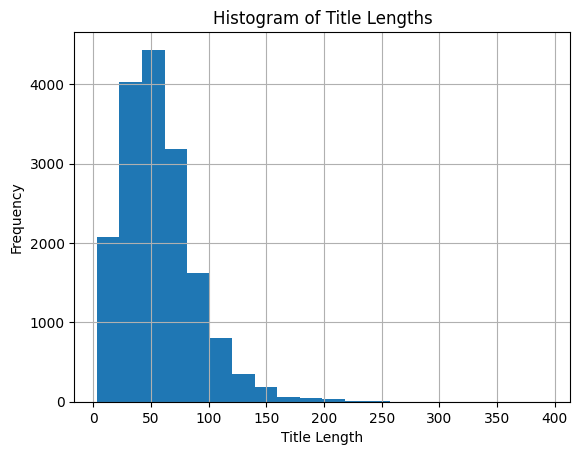

In [ ]:
plt.hist(nonciting_dataset_df['Title'].str.len(), bins=20)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.grid(True)
plt.show()


## 1.3 Number of CITED patents per citing patent

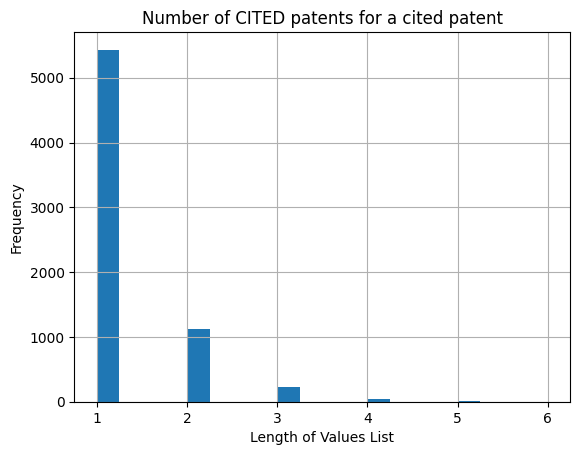

In [ ]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a cited patent')
plt.grid(True)
plt.show()


# 2.0 Doc2Vec

## 2.1 'Title'

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_train = create_corpus(json_citing_train , 'title')
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
title_citing_train[:5]

Number of documents without title: 0
Number of documents without title: 0
Number of documents without title: 0


[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'},
 {'id': '3694265A1',
  'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'},
 {'id': '3623522A1', 'text': 'LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME'},
 {'id': '3611147A1',
  'text': 'CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION TO ENHANCE COATING ADHESION AND COMPATIBILITY'},
 {'id': '3640454A1', 'text': 'FUEL METERING SYSTEM'}]

### 2.1.1 Initalize Word2Vec

In [ ]:
def train_doc2vec_model(corpus, vector_size=100, window=5, min_count=5, workers=4, epochs=20):
    """Trains a Doc2Vec model using the provided corpus."""
    tagged_data = [TaggedDocument(words=word_tokenize(_d['text'].lower()), tags=[str(_d['id'])]) for _d in corpus]
    model = Doc2Vec(tagged_data, vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    return model

In [ ]:
doc2vec_model = train_doc2vec_model(title_citing_train + title_nonciting)

In [ ]:
# Save the model
doc2vec_model.save("doc2vec_model_title.model")

In [ ]:
def create_document_embeddings(corpus, doc2vec_model):
    """Creates document embeddings using Doc2Vec."""
    document_embeddings = []
    for doc in tqdm(corpus, desc="Generating Embeddings"):
        document_embeddings.append(doc2vec_model.infer_vector(word_tokenize(doc['text'].lower())))
    return np.array(document_embeddings)

In [ ]:
# Create document embeddings for citing and cited patents:
citing_embeddings = create_document_embeddings(title_citing_train, doc2vec_model)
nonciting_embeddings = create_document_embeddings(title_nonciting, doc2vec_model)

Generating Embeddings:   0%|          | 0/6831 [00:00<?, ?it/s]

Generating Embeddings:   0%|          | 0/16837 [00:00<?, ?it/s]

### 2.1.2 Get Cosine similarities

In [ ]:
cosine_similarities = linear_kernel(citing_embeddings, nonciting_embeddings)
cosine_similarities

array([[ 9.22151729e-02,  7.27977082e-02,  7.52452165e-02, ...,
         5.43291830e-02,  4.87960689e-02, -4.52239886e-02],
       [ 7.22672865e-02,  1.38863042e-01, -1.19266473e-01, ...,
        -4.81516123e-04,  1.46957226e-02,  6.44064099e-02],
       [-3.48015726e-02, -8.80915672e-02,  2.12237891e-02, ...,
        -1.43676307e-02,  2.21059881e-02,  7.58311525e-02],
       ...,
       [-8.13381821e-02,  1.72352009e-02,  8.50752145e-02, ...,
        -6.72806278e-02,  4.11354229e-02, -5.54644212e-04],
       [ 1.24075949e-01,  2.67393500e-01, -9.01183560e-02, ...,
        -4.83613461e-04,  6.64022639e-02,  7.87056163e-02],
       [-1.08473055e-01, -1.89404771e-01,  1.15985289e-01, ...,
         2.11156189e-01, -4.77540009e-02, -2.52384925e-04]], dtype=float32)

### 2.1.3 Get Metrics

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_titles_doc2vec = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_doc2vec = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_doc2vec = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_doc2vec= mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_doc2vec, 4))
print("Recall at 20:", round(recall_at_20_titles_doc2vec, 4))
print("Recall at 50:", round(recall_at_50_titles_doc2vec, 4))
print("Recall at 100:", round(recall_at_100_titles_doc2vec, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

# Recall at 10: 0.0213
# Recall at 20: 0.0334
# Recall at 50: 0.058
# Recall at 100: 0.0825
# Mean ranking: 94.6681
# Mean average precision: 0.0082
# Number of patents measured: 6831
# Number of patents not in the citation: 0

Calculating MAP:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall at 10: 0.0213
Recall at 20: 0.0334
Recall at 50: 0.058
Recall at 100: 0.0825
Mean ranking: 94.6681
Mean average precision: 0.0082
Number of patents measured: 6831
Number of patents not in the citation: 0


## Full Text Doc2Vec

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
full_text_citing[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) positioned between the additio

In [ ]:
doc2vec_model_fulltext = train_doc2vec_model(full_text_citing + full_text_nonciting)

In [ ]:
doc2vec_model_fulltext.save("doc2vec_model_fulltext.model")

In [ ]:
fulltext_citing_embeddings = create_document_embeddings(full_text_citing, doc2vec_model_fulltext)
fulltext_nonciting_embeddings = create_document_embeddings(full_text_nonciting, doc2vec_model_fulltext)


Generating Embeddings:   0%|          | 0/6831 [00:00<?, ?it/s]

In [ ]:
# Calculate cosine similarities

cosine_similarities_fulltext = linear_kernel(fulltext_citing_embeddings, fulltext_nonciting_embeddings)

In [ ]:
# Get top k ranks
k = 100
top_k_rank_fulltext = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities_fulltext, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank_fulltext)

mean_rank_fulltext = mean_ranking(true_labels, predicted_labels)
mean_average_precision_fulltext = mean_average_precision(true_labels, predicted_labels)

recall_at_10_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=100)


print("Recall at 10:", round(recall_at_10_fulltext, 4))
print("Recall at 20:", round(recall_at_20_fulltext, 4))
print("Recall at 50:", round(recall_at_50_fulltext, 4))
print("Recall at 100:", round(recall_at_100_fulltext, 4))

print("Mean ranking:", round(mean_rank_fulltext, 4))
print("Mean average precision:", round(mean_average_precision_fulltext, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

# Recall at 10: 0.3642
# Recall at 20: 0.46
# Recall at 50: 0.5933
# Recall at 100: 0.6939
# Mean ranking: 45.1603
# Mean average precision: 0.2037
# Number of patents measured: 6831
# Number of patents not in the citation: 0


Calculating MAP:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall at 10: 0.3642
Recall at 20: 0.46
Recall at 50: 0.5933
Recall at 100: 0.6939
Mean ranking: 45.1603
Mean average precision: 0.2037
Number of patents measured: 6831
Number of patents not in the citation: 0
